In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn as sk

import tensorflow.experimental.numpy as tnp
tnp.experimental_enable_numpy_behavior()

from skimage.transform import resize

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Input, Flatten,\
                                    Reshape, LeakyReLU as LR,\
                                    Activation, Dropout, Conv2D, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.models import Model, Sequential
from matplotlib import pyplot as plt
from IPython import display # If using IPython, Colab or Jupyter
import numpy as np
from time import time

from numba import jit, float32, vectorize, guvectorize
import math


In [2]:
!nvidia-smi

Wed Sep 28 10:29:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


2022-09-28 10:29:14.160098: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-28 10:29:14.225204: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-28 10:29:14.317950: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-28 10:29:14.319109: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

imporing mnist

In [4]:
# (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = (x_train/256-0.5).astype('float32') 
x_test = (x_test/256-0.5).astype('float32') 

11501568/11490434 [==============================] - 0s 0us/step


In [5]:
x_train = x_train#[y_train == 2]
x_test = x_test#[y_test == 2]

In [6]:
SIZE = 28

PATCH_SIZE = 10

OVER_PATCH = 4



In [7]:
test_vec = x_train[110]

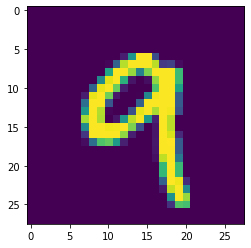

In [8]:
plt.imshow(test_vec)

In [9]:
def patch_creation(image):
    '''
This function is used to convert an image in the patched version that can be used for the vision transformer.

## Inputs:
* image: a numpy array of shape (size,size).

## Outputs:   
* an array of shape ((size/2)**2, 2, 2).

note: the size must be an even number.
    '''
    
    out = list()
    
    size = image.shape[0]
    for i in range(int((size-2*OVER_PATCH)/PATCH_SIZE)):
        for j in range(int((size-2*OVER_PATCH)/PATCH_SIZE)):
            out.append(image[i*PATCH_SIZE:i*PATCH_SIZE+PATCH_SIZE+2*OVER_PATCH, j*PATCH_SIZE:j*PATCH_SIZE+PATCH_SIZE+2*OVER_PATCH])
    return np.array(out)

In [10]:
patched_example = patch_creation(test_vec)
patched_example.shape

(4, 18, 18)

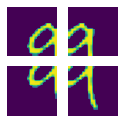

In [11]:
fig, ax = plt.subplots(nrows=int(SIZE/PATCH_SIZE), ncols=int(SIZE/PATCH_SIZE), figsize=(int(SIZE/PATCH_SIZE),int(SIZE/PATCH_SIZE)))



for i in range(int((SIZE-2*OVER_PATCH)/PATCH_SIZE)):
    for j in range(int((SIZE-2*OVER_PATCH)/PATCH_SIZE)):
#         print(f'i: {i}')
#         print(f'j: {j}')
#         print(f'i*j: {j+ 10*i}')
        ax[i,j].imshow(patched_example[j+ int((SIZE-2*OVER_PATCH)/PATCH_SIZE)*i], vmin=0, vmax=0.5)
        ax[i,j].axis('off')
plt.show()

In [12]:
#this is the most efficent

@guvectorize([(float32[:,:,:], float32[:,:,:], float32[:,:,:])],
             "(m, n, n), (m, q, p)->(m, q, p)", nopython=True)       
# note the trick used to ouput a matrix with dimensions q and p, that never appears in the input!
# this is probably just a limitation of numba
# also note the fact that guvectorize does not have a return! the output arguments has to be the last input! 
def patch_creation_vec(images, out, out_1):

    '''
This function is used to convert a set of images in their patched version. This function is vectorized for speed and can be used efficently in the data generator.

## Inputs:
* images: a numpy array of shape (n_images, size,size).
* out_1: output array to be overwritten in the shape (n_images, (size/2)**2, 2, 2).
* out: output array to be overwritten in the shape (n_images, (size/2)**2, 2, 2), this second input is needed because the the shapes (size/2)**2 and  4 do not appear in the first array.

## Outputs:   
* an array of shape (n_images, (size/2)**2, 4).

### notes:
1) The size must be an even number.
2) Since the function uses guvectorize, the output will be returned via in-place modification of the last input argument.

    '''


    for m in range(images.shape[0]):
        c=0
        for i in range(int((SIZE-2*OVER_PATCH)/PATCH_SIZE)):
            for j in range(int((SIZE-2*OVER_PATCH)/PATCH_SIZE)):
                # we need to use the ascontiguousarray function in order to be able to reshape the array in numba
                out[m, c,:] = np.ascontiguousarray(images[m,
                                                          i*PATCH_SIZE:i*PATCH_SIZE+PATCH_SIZE+2*OVER_PATCH,
                                                          j*PATCH_SIZE:j*PATCH_SIZE+PATCH_SIZE+2*OVER_PATCH])\
                                .reshape((PATCH_SIZE+2*OVER_PATCH)**2)#+1/(c+1)
                c+=1 

In [13]:
def recompose(patched_image):
    '''
This function is used to recompose an image from its pathced version.

## Inputs:
* patched_image: a numpy array of shape ((size/2)**2, 4).

## Outputs:   
* an array of shape (size, size).

### notes:
1) The size must be an even number.

    '''
    recomposed = np.zeros(shape=(SIZE,SIZE))
    counts = np.zeros(shape=(SIZE,SIZE))

    c = 0
    for i in range(int((SIZE-2*OVER_PATCH)/PATCH_SIZE)):
        for j in range(int((SIZE-2*OVER_PATCH)/PATCH_SIZE)):
            recomposed[i*PATCH_SIZE:i*PATCH_SIZE+PATCH_SIZE+2*OVER_PATCH,
                       j*PATCH_SIZE:j*PATCH_SIZE+PATCH_SIZE+2*OVER_PATCH] = (patched_image[c].reshape(PATCH_SIZE+2*OVER_PATCH, PATCH_SIZE+2*OVER_PATCH)) + \
                                                                             recomposed[i*PATCH_SIZE:i*PATCH_SIZE+PATCH_SIZE+2*OVER_PATCH,
                                                                                        j*PATCH_SIZE:j*PATCH_SIZE+PATCH_SIZE+2*OVER_PATCH]
            c+=1
            counts[i*PATCH_SIZE:i*PATCH_SIZE+PATCH_SIZE+2*OVER_PATCH,
                       j*PATCH_SIZE:j*PATCH_SIZE+PATCH_SIZE+2*OVER_PATCH] += 1
    
    recomposed = recomposed/counts

    return recomposed



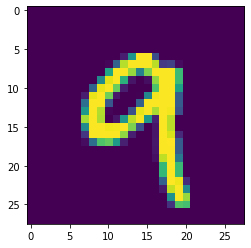

In [14]:
plt.imshow(recompose(patched_example))

## reparametrization

$$\forall i,j  ~~~ N_{i,j} = \mathcal{N}  $$
$$Noised\_Immage = (\alpha^n)Immage + N(1-\alpha^n)$$

when:
$$n\rightarrow\inf \implies Noised\_Immage=N$$ 
$n$ is the number of steps of perturbation


In [15]:
# n_repeat allows us to present the same image multiple times in the same batch with different type of noise!

def add_noise(imm, alpha=0.9, n_max=100, n_repeat=1):
        
    '''
This function is used add the noise to a set of images. The added noise is randomly scaled to correspond to a uniform choice of diffusion step between 0 and n_max.
The resulting vector is a set of images with various noise level added.

## Inputs:
* imm: an numpy array of images. Shape: (n_images, size, size).
* alpha: scaling of the noise to add in one step. The more alpha is close to one the less noise is added at every step of the diffusion process.
* n_max: maximum number of steps of the diffusion process.
* n_repeat: if this parameter is different from 1 the same images is used n_repeat to generate noised images.

## Outputs:   
* noised_image: a numpy array of noised images. Shape: (n_images*n_repeat, size, size). This will be the main input of the ML algorithm.
* g_noise_to_add: a numpy array of the added noised, not rescaled by alpha. Shape: (n_images*n_repeat, size, size). This will be the target of the ML algorithm.
* array_alphas_n: a numpy array of the used alphas. Shape: (n_images*n_repeat,). This will be part of input of the ML algorithm.
    '''
    imm = np.tile(imm,(n_repeat,1,1))
    shape = imm.shape
    g_noise_to_add = np.random.randn(*shape)

    array_alphas_n = np.ones(shape[0])*alpha**np.random.randint(0, n_max + 1, shape[0]) 

    noised_image = np.einsum('i, ikj -> ikj', array_alphas_n,  imm) +\
             np.einsum('i, ikj -> ikj', 1-array_alphas_n,  g_noise_to_add)
    return noised_image, g_noise_to_add, array_alphas_n

In [16]:
def add_noise_contolled(imm, alpha=0.9, n=100, n_repeat=1):
    '''
This function is used add the noise to a set of images. The added noise is scaled to correspond to n-esim step of the diffiusion process.
The resulting vector is a set of images with fixed noise level added.

## Inputs:
* imm: an numpy array of images. Shape: (n_images, size, size).
* alpha: scaling of the noise to add in one step. The more alpha is close to one the less noise is added at every step of the diffusion process.
* n: target step of the diffusion process.
* n_repeat: if this parameter is different from 1 the same images is used n_repeat times to generate noised images.

## Outputs:   
* noised_image: a numpy array of noised images. Shape: (n_images*n_repeat, size, size). This will be the main input of the ML algorithm.
* g_noise_to_add: a numpy array of the added noised, not rescaled by alpha. Shape: (n_images*n_repeat, size, size). This will be the target of the ML algorithm.
* array_alphas_n: a numpy array of the used alphas. Shape: (n_images*n_repeat,). This will be part of input of the ML algorithm.
    '''
    imm = np.tile(imm,(n_repeat,1,1))
    shape = imm.shape
    g_noise_to_add = np.random.randn(*shape)

    array_alphas_n = np.ones(shape[0])*alpha**n 

    noised_image = np.einsum('i, ikj -> ikj', array_alphas_n,  imm) +\
             np.einsum('i, ikj -> ikj', 1-array_alphas_n,  g_noise_to_add)
    return noised_image, g_noise_to_add, array_alphas_n

# creation of the generator

In [17]:
class CustomDataGen(tf.keras.utils.Sequence):
    
    '''
This is the main CustomDataGenerator 
    '''
    
    
    def __init__(self, 
                 X,
                 y,
                 batch_size,
                 n_repeat=1,
                 alpha=0.9,
                 n_max=100):
            
        '''
This is the main CustomDataGenerator 

## Inputs:
* X: base dataset
* y: label list
* batch_size: batch size 
* n_repeat: if this parameter is different from 1 the same images is used n_repeat times to generate noised images.
* alpha: scaling of the noise to add in one step. The more alpha is close to one the less noise is added at every step of the diffusion process.
* n_max: maximum number of steps of the diffusion process.
        '''
        
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.n_repeat = n_repeat
        self.alpha=alpha
        self.n_max=n_max

   
    def __get_data(self, index):
        

        noised_imms, random_noise_to_add, alphas_n = add_noise(self.X[index:index+self.batch_size],
                                                           n_repeat=self.n_repeat,
                                                           alpha=self.alpha,
                                                           n_max=self.n_max) 

#         lables = self.y[index:index+self.batch_size]
#         lables = np.tile(lables,(self.n_repeat))
        
#         lables = (1/(lables+1))
        out_noised_imms = np.zeros(shape=(noised_imms.shape[0],
                                          int((SIZE-2*OVER_PATCH)/PATCH_SIZE)**2,
                                          (PATCH_SIZE+2*OVER_PATCH)**2)).astype('float32') 
        out_random_noise_to_add = np.zeros(shape=(random_noise_to_add.shape[0],
                                                  int((SIZE-2*OVER_PATCH)/PATCH_SIZE)**2,
                                                  (PATCH_SIZE+2*OVER_PATCH)**2)).astype('float32')
        noised_imms = noised_imms.astype('float32')
        random_noise_to_add = random_noise_to_add.astype('float32')

        patched_noised_imm = patch_creation_vec(noised_imms, out_noised_imms, out_noised_imms).reshape(-1,  
                                                                                                       int((SIZE-2*OVER_PATCH)/PATCH_SIZE)**2,
                                                                                                       (PATCH_SIZE+2*OVER_PATCH)**2)
        
        # we concatenate to the patched images two other information, the used alphas_n and the labels
        return (np.concatenate([patched_noised_imm,
                                np.einsum('i, ikj -> ikj',
                                          alphas_n, 
                                          np.ones((patched_noised_imm.shape[0],1,patched_noised_imm.shape[2]))),
#                                 np.einsum('i, ikj -> ikj',
#                                           lables, 
#                                           np.ones((patched_noised_imm.shape[0],1,patched_noised_imm.shape[2]))),

                             ],
                             axis=1),
              patch_creation_vec(random_noise_to_add, out_random_noise_to_add, out_random_noise_to_add).reshape(-1,  
                                                                                                                int((SIZE-2*OVER_PATCH)/PATCH_SIZE)**2,
                                                                                                                (PATCH_SIZE+2*OVER_PATCH)**2))
    
    def __getitem__(self, index):

        return self.__get_data(index) 
    
    def __len__(self):
        return  math.floor(self.X.shape[0]/self.batch_size)
    # potrebbe essere necessario presentare molte più versioni del rumore? in fondo queste sono infinitamente facilmente creabili

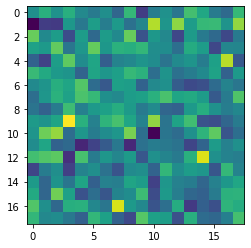

In [18]:
#testing generator:

gen = CustomDataGen(x_train, y_train, 50)

patch_testing = gen.__getitem__(5)[0]

plt.imshow(patch_testing[0][3].reshape(PATCH_SIZE+2*OVER_PATCH, PATCH_SIZE+2*OVER_PATCH))

In [19]:
patch_testing.shape

(50, 5, 324)

In [20]:
# creating_val_data
ALPHA=0.99
N_MAX=500

val_gen =  CustomDataGen(x_test, y_test, 800, alpha=ALPHA,  n_max=N_MAX)
validation_data = val_gen.__getitem__(1)  

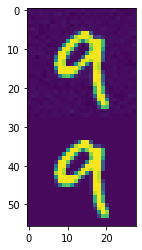

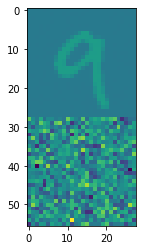

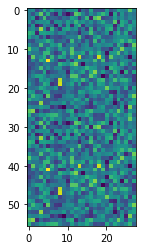

In [21]:
imm = test_vec

imm_noised_1, noise1, _ = add_noise_contolled(imm, alpha=ALPHA, n=1)
imm_noised_2, noise2, _ = add_noise_contolled(imm, alpha=ALPHA, n=N_MAX)
  
imm_noised_1 = imm_noised_1.reshape(SIZE, SIZE)
imm_noised_2 = imm_noised_2.reshape(SIZE, SIZE)
noise1 = noise1.reshape(SIZE,SIZE)
noise2 = noise2.reshape(SIZE,SIZE)


plt.imshow(np.concatenate([imm_noised_1, imm]))
plt.show()
plt.imshow(np.concatenate([imm_noised_1, noise1]))
plt.show()
plt.imshow(np.concatenate([imm_noised_2, noise2]))
plt.show()

In [22]:
ALPHA_N_MAX = ALPHA**N_MAX

In [23]:
validation_data[0].shape

(800, 5, 324)

## 

In [24]:
EPOCH = 200
PATIENCE = 5
BATCH_SIZE = 5
LR = 0.0001
N_REPEAT = 100

In [25]:
# this keras layer is used to add a trainable positional enconding to the patches!
class PositionPatchEncoder(tf.keras.layers.Layer):
    def __init__(self):
        super(PositionPatchEncoder, self).__init__()
        self.position_embedding = tf.keras.layers.Embedding(input_dim=int((SIZE-2*OVER_PATCH)/PATCH_SIZE)**2,
                                                            output_dim=(PATCH_SIZE+2*OVER_PATCH)**2)

    def call(self, patch):
        positions = tf.range(start=0, limit=int((SIZE-2*OVER_PATCH)/PATCH_SIZE)**2+1, delta=1)
        encoded = patch + self.position_embedding(positions)
        return encoded

In [41]:

def create_model():
    
    input_tensor = tf.keras.Input(shape=[int((SIZE-2*OVER_PATCH)/PATCH_SIZE)**2+1, (PATCH_SIZE+2*OVER_PATCH)**2])

    # Adding the positional encoding  
    x_start = PositionPatchEncoder()(input_tensor)

    # The use of residual connections has been instrumental in the agorithm actualy learning
    x_mod = tf.keras.layers.MultiHeadAttention(num_heads=100, key_dim=100)(x_start, x_start)
    x = tf.keras.layers.Add()([x_mod, x_start])
#     x_mod = tf.keras.layers.MultiHeadAttention(num_heads=10, key_dim=100)(x, x)
#     x = tf.keras.layers.Add()([x_mod, x_start])
#     x_mod = tf.keras.layers.MultiHeadAttention(num_heads=10, key_dim=100)(x, x)
#     x = tf.keras.layers.Add()([x_mod, x_start])
#     x_mod = tf.keras.layers.MultiHeadAttention(num_heads=10, key_dim=100)(x, x)
#     x = tf.keras.layers.Add()([x_mod, x_start])
#     x_mod = tf.keras.layers.MultiHeadAttention(num_heads=10, key_dim=100)(x, x)
#     x = tf.keras.layers.Add()([x_mod, x_start])


    
    out = tf.keras.layers.Lambda(lambda x: x[:,:int((SIZE-2*OVER_PATCH)/PATCH_SIZE)**2])(x)

    temp_model = tf.keras.Model(inputs=input_tensor, outputs=out)
    
    return temp_model

gen = CustomDataGen(x_train[:], y_train[:], BATCH_SIZE, alpha=ALPHA,  n_max=N_MAX, n_repeat=N_REPEAT)

# Create a new model instance
temp_model = create_model()

# Restore the weights uncomment and change the model path to use the preloaded model 
# temp_model.load_weights('../input/diffusion-transformer-multlabel-for-real/model_1')  

opt = tf.keras.optimizers.Adam(
learning_rate=LR,
#clipvalue=1.0

)
call_stop = tf.keras.callbacks.EarlyStopping(
  monitor='val_loss',
  patience=PATIENCE,
  restore_best_weights=True
)
temp_model.compile(opt, loss = "mse")
temp_model.summary()

# TRAINING
# comment to avoid retraining the model
with tf.device('/GPU:0'):
    temp_model.fit(gen, epochs=EPOCH, batch_size=BATCH_SIZE, validation_data=validation_data, callbacks=[call_stop])

# Save the weights
temp_model.save_weights(f'./model_{1}') 



    

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 5, 324)]     0                                            
__________________________________________________________________________________________________
position_patch_encoder_1 (Posit (None, 5, 324)       1296        input_2[0][0]                    
__________________________________________________________________________________________________
multi_head_attention_1 (MultiHe (None, 5, 324)       12990324    position_patch_encoder_1[0][0]   
                                                                 position_patch_encoder_1[0][0]   
__________________________________________________________________________________________________
add_1 (Add)                     (None, 5, 324)       0           multi_head_attention_1[0][0

KeyboardInterrupt: 

In [42]:
def noise_remove(noise, noised_imm, alpha, n=1):
    '''
This function uses a predicted noise to try and remove the noise. It does can do more step inverse diffusion process in one shoot.

## Inputs:
* noise: an image of shape (SIZE,SIZE) containining the noise to remove
* noised_imm: an image of shape (SIZE,SIZE) image to denoise
* alpha: scaling of the noise to add in one step. The more alpha is close to one the less noise is added at every step of the diffusion process.
* n: number of steps of noise to be removed.

## Outputs:   
The output is the denoised image
    '''

    return (noised_imm - noise*(1-alpha**n))/(alpha**n)

(4, 18, 18)


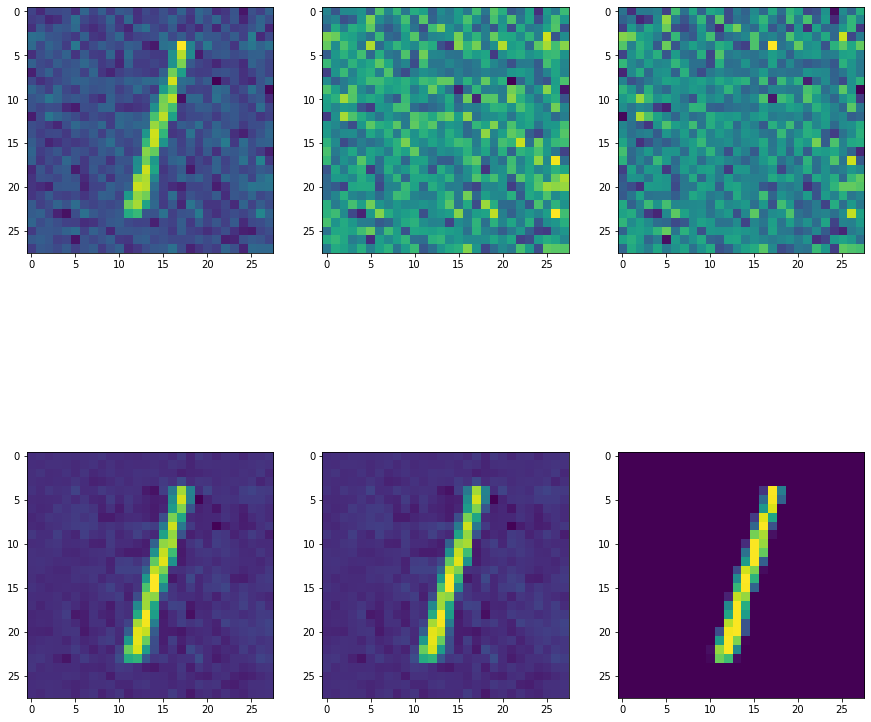

In [43]:
FIG_N = 2
ALPHA=0.9
N=1

# temp_model = create_model()
# temp_model.load_weights(f'./model_{1}')  
    
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,15))

n_imm, noise, _ = add_noise_contolled(x_test[FIG_N], alpha=ALPHA, n=1)

n_imm = n_imm.reshape(SIZE,SIZE) 
noise = noise.reshape(SIZE,SIZE)

ax[0][0].imshow(n_imm)
ax[0][1].imshow(noise)


patched_n_imm = patch_creation(n_imm)
print(patched_n_imm.shape)

noise_pred = temp_model.predict(np.concatenate([patched_n_imm.reshape(1, patched_n_imm.shape[0], (PATCH_SIZE+2*OVER_PATCH)**2),
                                                ALPHA*np.ones((1,1,(PATCH_SIZE+2*OVER_PATCH)**2))
                                               ], axis=1)).reshape(int((SIZE-2*OVER_PATCH)/PATCH_SIZE)**2, (PATCH_SIZE+2*OVER_PATCH)**2)
ax[0][2].imshow(recompose(noise_pred))

# # implied image

ax[1][0].imshow(noise_remove(recompose(noise_pred),
                             n_imm.reshape(SIZE,SIZE),
                             alpha=ALPHA))
ax[1][1].imshow(noise_remove(recompose(noise_pred),
                             n_imm.reshape(SIZE,SIZE),
                             alpha=ALPHA,
                             n=N))

ax[1][2].imshow(x_test[FIG_N].reshape(SIZE,SIZE))

In [69]:
N_2 = 50
ALPHA2 = (ALPHA_N_MAX)**(1/N_2)

In [70]:
print(N_2)
print(ALPHA2)
print(ALPHA2**N_2)

50
0.9043820750088044
0.006570483042414603


0.006570483042414603


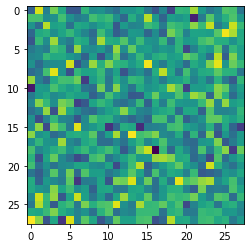

50


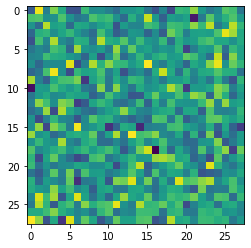

40


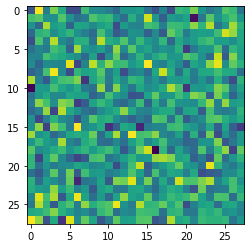

30


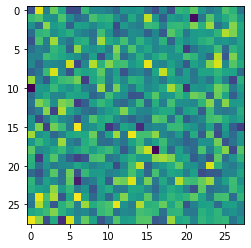

20


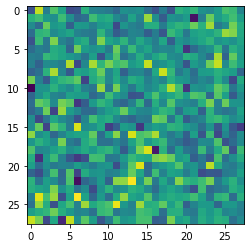

10


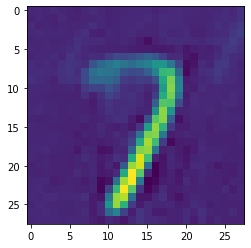

In [71]:
noised_imm = np.random.randn(SIZE, SIZE) 

ALPHA = ALPHA2
N = N_2
STEP = 1
print(ALPHA**N)

for n in range(N, 0 ,-STEP):
    if n%(10*STEP) == 0:
        plt.imshow(noised_imm)
        plt.show()
        print(n)
    alpha = (ALPHA)**n
    patched_n_imm = patch_creation(noised_imm.reshape(SIZE,SIZE))
    noise_pred = temp_model.predict(np.concatenate([patched_n_imm.reshape(1, patched_n_imm.shape[0], (PATCH_SIZE+2*OVER_PATCH)**2),
                                                    alpha*np.ones((1,1,(PATCH_SIZE+2*OVER_PATCH)**2))
                                                   ], axis=1))\
                           .reshape(int((SIZE-2*OVER_PATCH)/PATCH_SIZE)**2, (PATCH_SIZE+2*OVER_PATCH)**2)


    noised_imm = noise_remove(recompose(noise_pred.reshape(int((SIZE-2*OVER_PATCH)/PATCH_SIZE)**2, (PATCH_SIZE+2*OVER_PATCH)**2)),
             noised_imm.reshape(SIZE,SIZE),
             alpha=ALPHA,
             n=1.5*STEP)

plt.imshow(noised_imm)
plt.show()

0.006570483042414603
fig n: 0
fig n: 1
fig n: 2
fig n: 3
fig n: 4
fig n: 5
fig n: 6
fig n: 7
fig n: 8
fig n: 9
fig n: 10
fig n: 11
fig n: 12
fig n: 13
fig n: 14
fig n: 15


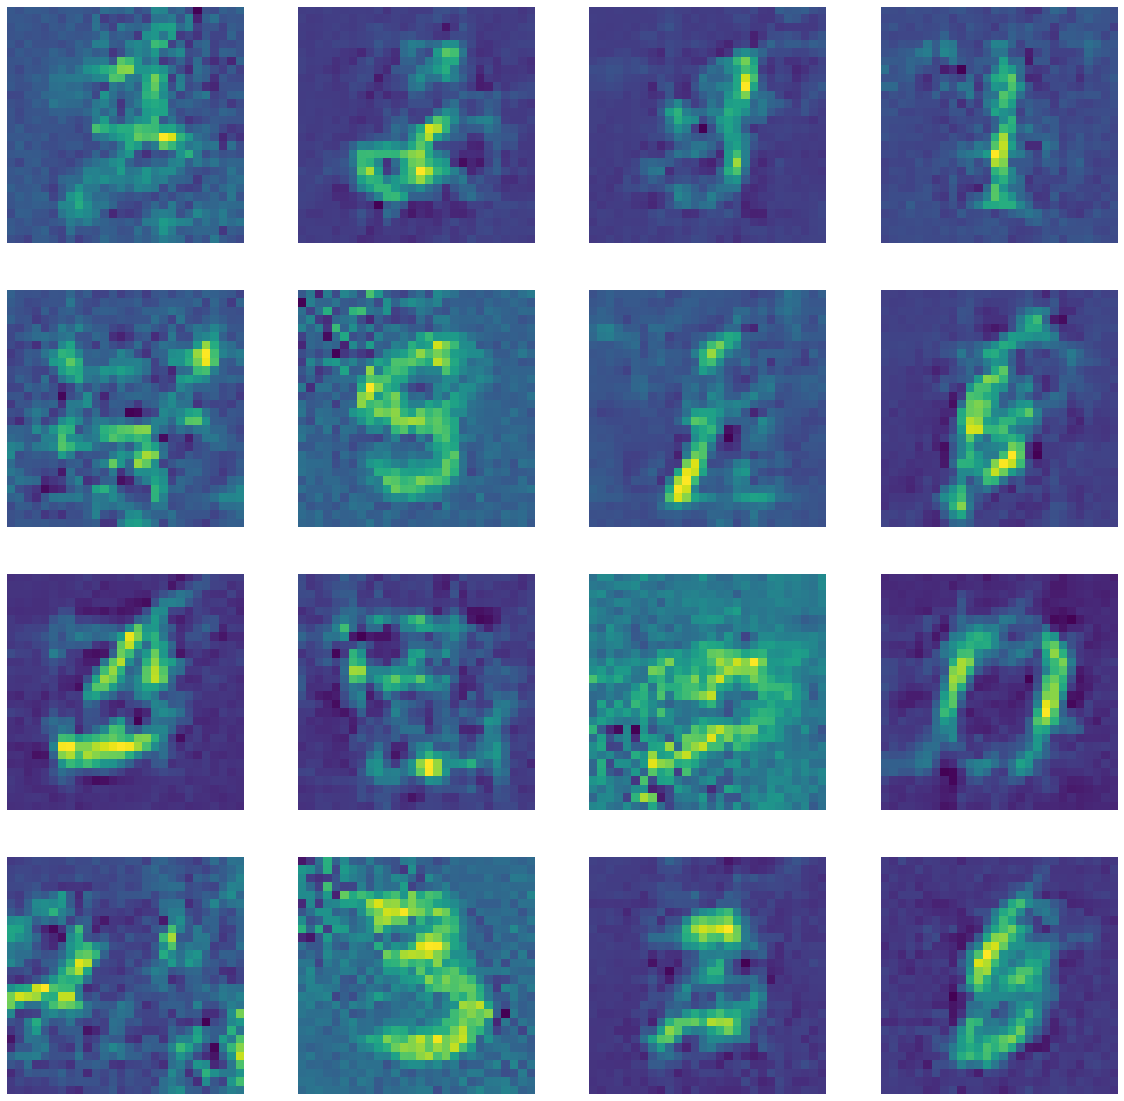

In [76]:
number = 4

fig, ax = plt.subplots(nrows=number, ncols=number, figsize=(20,20))




ALPHA = ALPHA2
N = N_2
STEP = 1
print(ALPHA**N)

c = 0



for i in range(number**2):
    print(f'fig n: {i}')
    noised_imm = np.random.randn(SIZE, SIZE) #np.concatenate([np.random.randn(SIZE, SIZE)[:,:14], x_test[imm_n][:,14:]], axis=1) # np.random.randn(SIZE, SIZE)#  #
    #noised_imm, _ = add_noise(x_test[FIG_N], n=N_STEPS, beta=BETA)

    noised_imm = noised_imm.reshape(SIZE,SIZE) 
    for n in range(N, 0 ,-STEP):
        if n%(100*STEP) == 0:
            print(n)
        alpha = (ALPHA)**n
        patched_n_imm = patch_creation(noised_imm.reshape(SIZE,SIZE))
        noise_pred = temp_model.predict(np.concatenate([patched_n_imm.reshape(1, patched_n_imm.shape[0], (PATCH_SIZE+2*OVER_PATCH)**2),
                                                        alpha*np.ones((1,1,(PATCH_SIZE+2*OVER_PATCH)**2))
                                                       ], axis=1))\
                               .reshape(int((SIZE-2*OVER_PATCH)/PATCH_SIZE)**2, (PATCH_SIZE+2*OVER_PATCH)**2)


        noised_imm = noise_remove(recompose(noise_pred.reshape(int((SIZE-2*OVER_PATCH)/PATCH_SIZE)**2, (PATCH_SIZE+2*OVER_PATCH)**2)),
                 noised_imm.reshape(SIZE,SIZE),
                 alpha=ALPHA,
                 n=STEP)
            
    ax[int(i/number),i%number].imshow(noised_imm)
    ax[int(i/number),i%number].axis('off')

    
    

plt.show()

0.006570483042414603
fig n: 0
fig n: 1
fig n: 2
fig n: 3
fig n: 4
fig n: 5
fig n: 6
fig n: 7
fig n: 8
fig n: 9
fig n: 10
fig n: 11
fig n: 12
fig n: 13
fig n: 14
fig n: 15


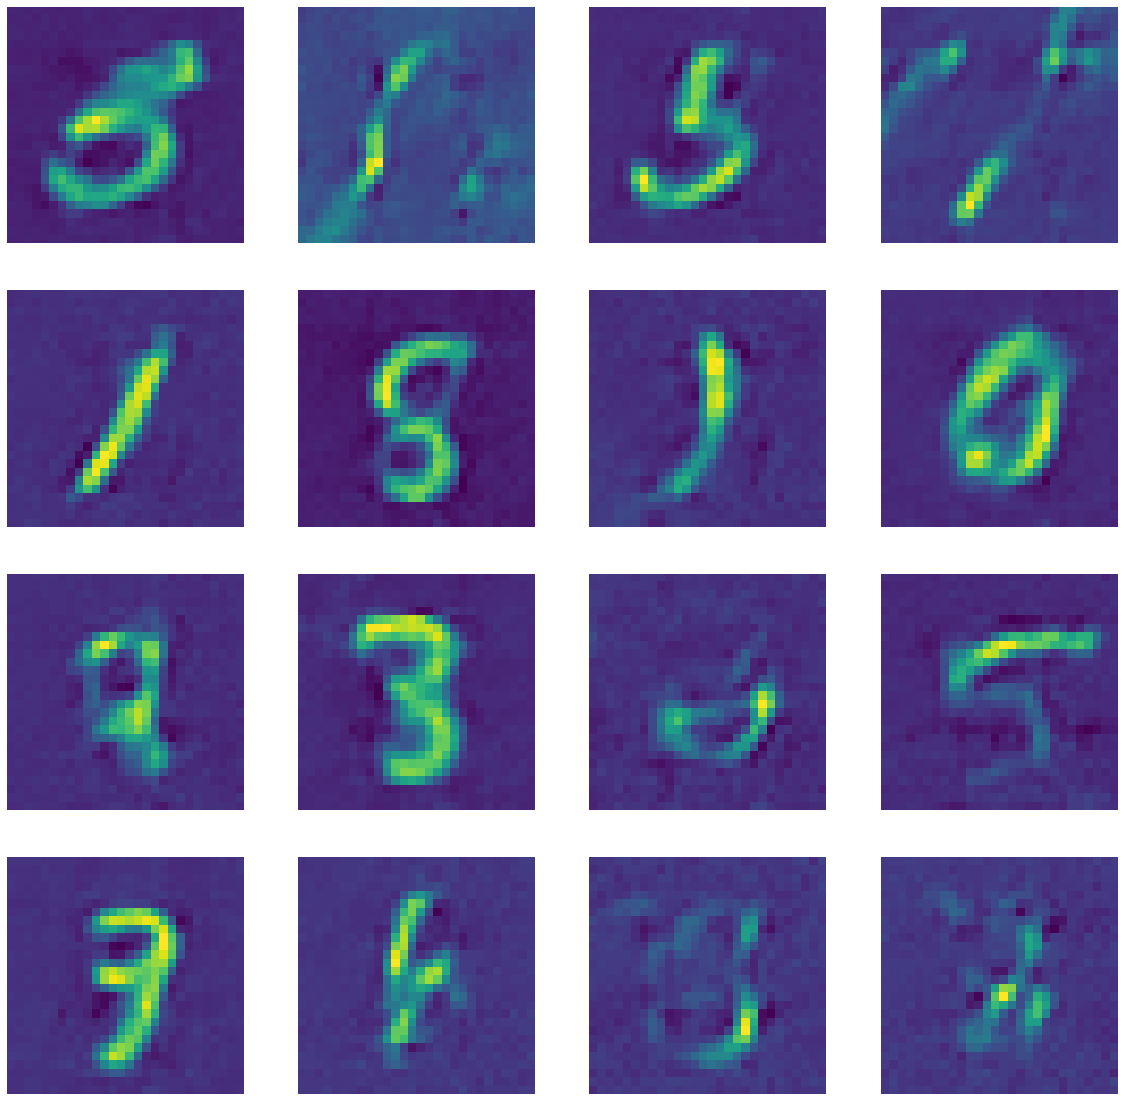

In [75]:
number = 4

fig, ax = plt.subplots(nrows=number, ncols=number, figsize=(20,20))




ALPHA = ALPHA2
N = N_2
STEP = 1
print(ALPHA**N)

c = 0



for i in range(number**2):
    print(f'fig n: {i}')
    noised_imm = np.random.randn(SIZE, SIZE) #np.concatenate([np.random.randn(SIZE, SIZE)[:,:14], x_test[imm_n][:,14:]], axis=1) # np.random.randn(SIZE, SIZE)#  #
    #noised_imm, _ = add_noise(x_test[FIG_N], n=N_STEPS, beta=BETA)

    noised_imm = noised_imm.reshape(SIZE,SIZE) 
    for n in range(N, 0 ,-STEP):
        if n%(100*STEP) == 0:
            print(n)
        alpha = (ALPHA)**n
        patched_n_imm = patch_creation(noised_imm.reshape(SIZE,SIZE))
        noise_pred = temp_model.predict(np.concatenate([patched_n_imm.reshape(1, patched_n_imm.shape[0], (PATCH_SIZE+2*OVER_PATCH)**2),
                                                        alpha*np.ones((1,1,(PATCH_SIZE+2*OVER_PATCH)**2))
                                                       ], axis=1))\
                               .reshape(int((SIZE-2*OVER_PATCH)/PATCH_SIZE)**2, (PATCH_SIZE+2*OVER_PATCH)**2)


        noised_imm = noise_remove(recompose(noise_pred.reshape(int((SIZE-2*OVER_PATCH)/PATCH_SIZE)**2, (PATCH_SIZE+2*OVER_PATCH)**2)),
                 noised_imm.reshape(SIZE,SIZE),
                 alpha=ALPHA,
                 n=1.5*STEP)
            
    ax[int(i/number),i%number].imshow(noised_imm)
    ax[int(i/number),i%number].axis('off')

    
    

plt.show()

0.006570483042414603


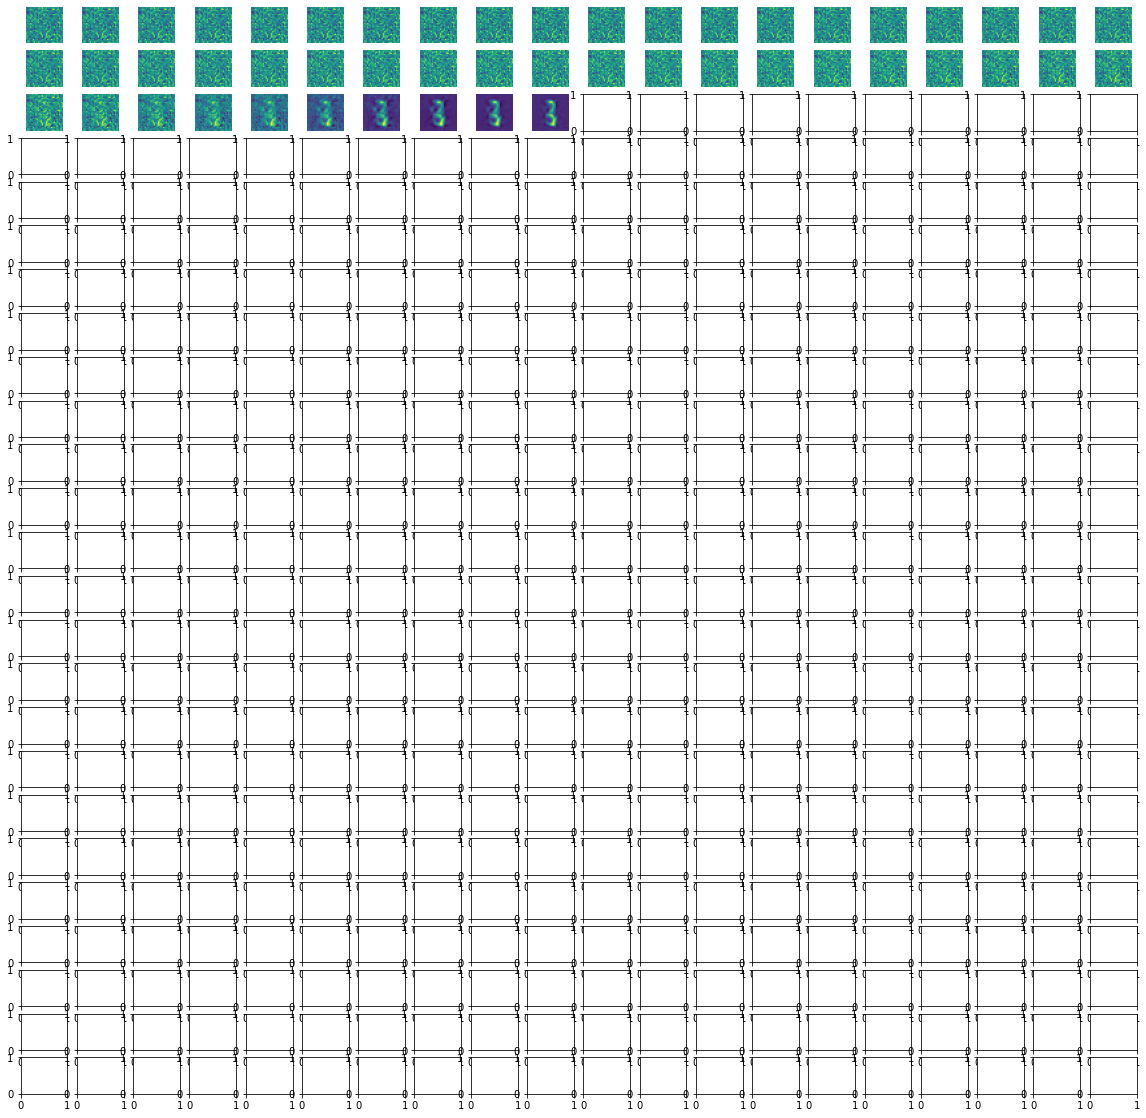

In [74]:
fig, ax = plt.subplots(nrows=25, ncols=20, figsize=(20,20))

noised_imm = np.random.randn(SIZE, SIZE) 

ALPHA = ALPHA2
N = N_2
STEP = 1
print(ALPHA**N)

c = 0
for n in range(N, 0 ,-STEP):
    if n%(100*STEP) == 0:
        print(n)
    alpha = (ALPHA)**n
    patched_n_imm = patch_creation(noised_imm.reshape(SIZE,SIZE))
    noise_pred = temp_model.predict(np.concatenate([patched_n_imm.reshape(1, patched_n_imm.shape[0], (PATCH_SIZE+2*OVER_PATCH)**2),
                                                    alpha*np.ones((1,1,(PATCH_SIZE+2*OVER_PATCH)**2))
                                                   ], axis=1))\
                           .reshape(int((SIZE-2*OVER_PATCH)/PATCH_SIZE)**2, (PATCH_SIZE+2*OVER_PATCH)**2)


    noised_imm = noise_remove(recompose(noise_pred.reshape(int((SIZE-2*OVER_PATCH)/PATCH_SIZE)**2, (PATCH_SIZE+2*OVER_PATCH)**2)),
             noised_imm.reshape(SIZE,SIZE),
             alpha=ALPHA,
             n=1.5*STEP)
    
    ax[int(c/20),c%20].imshow(noised_imm)
    ax[int(c/20),c%20].axis('off')
    c+=1
    
plt.show()